In [2]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

import hdf5storage # you need to pip install this to handle matlab > 7.3 files or something
import pickle

import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, pearsonr, spearmanr
import statsmodels.formula.api as smf

from fooof import FOOOF

# plotting stuff
import seaborn as sns
sns.set_style('whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})

import matplotlib
import matplotlib.pyplot as plt

# plot settings
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'regular',
        'size'   : 13}
figure = {'figsize' : (16,8)}

matplotlib.rc('font', **font)
matplotlib.rc('figure', **figure)


In [3]:
# windowed fft
def get_power(data, fs):
    data = data - np.mean(data) # de-mean; not necessary, strictly speaking
    data = data * np.hamming(len(data)) # window
    p = np.abs(np.fft.rfft(data))**2 # real fft, power
    f = np.linspace(0, fs/2, len(p)) # frequencies
    return f, p

# find the index that corresponds to the desired point in time
def index_of_nearest_timepoint(list_of_times, timepoint):
    time_idx = np.where(list_of_times>=timepoint)
    idx = time_idx[0][0]
    return idx

# gao's knee-to-tau conversion
def convert_knee_val(knee, exponent=2.):
    """
    Convert knee parameter to frequency and time-constant value.
    Can operate on array or float.

    Default exponent value of 2 means take the square-root, but simulation shows
    taking the exp-th root returns a more accurate drop-off frequency estimate
    when the PSD is actually Lorentzian.
    """
    knee_freq = knee**(1./exponent)
    knee_tau = 1./(2*np.pi*knee_freq)
    return knee_freq, knee_tau


In [4]:
# set up all the settings: analyze only OFC/PFC data
    # exclude s3 because their spectra are super noisy with lots of failed fits

# list of data directories, one for each subject
# dirs = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
# subs_fs = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 512, 512, 1000]

dirs = ['s1', 's2', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
subs_fs = [1000, 1000, 1000, 1000, 1000, 1000, 512, 512, 1000]

# these are the pfc+ofc channels for each subject
pfc = [['RCD8','RCD9','RCD10','ROF6','ROF7','ROF8','ROF9','ROF10','ROF1','ROF2','ROF3','ROF4','ROF5'],
       ['LIN10','RC8','LIN14','RC9','LIN15','RC10','LIN16','RC11','RC12','ROF11','ROF12','ROF13','ROF14','ROF15','ROF16','ROF2','ROF3','ROF4'],
#        ['LOF5','ROF7','LOF6','ROF8', 'LOF2'],
       ['LCI5','ROF7','LCI6','ROF8','LCI7','RCI5','LCI8','RCI6','LCI9','RCI7','RCI8','RCI9','ROF1','ROF2'],
       ['LTG17','LTG25','LTG26','LTG33','LTG34','LTG35','LTG41','LTG42','LTG43','LTG44','OFG1','OFG2','OFG3','OFG4','OFG6','OFG7','OFG8','OFG9','OFG11','OFG12','OFG13','OFG14','OFG16','OFG17','OFG18','OFG19'],
       ['PF2','PF3','PF4','PF5','PF6','FG4','FG5','FG6','FG7','FG11','FG12','FG13','FG14','FG15','FG17','FG18','FG19','FG20','FG21','FG22','FG23','FG25','FG26','FG27','FG28','FG29','FG30','FG31','AOF1','AOF2','AOF3','AOF4','AOF5','MOF1','MOF2','MOF3','MOF4','MOF5','POF1','POF2','POF3','POF4','POF5','FG2','FG3','FG9','FG10'],
       ['LOF6','ROF9','LOF7','RAC9','LOF8','RAC10','LOF9','RIN7','LIN3','RIN8','LIN4','RIN9','LIN5','LIN6','LIN7','LIN8','LIN9','LOF2','ROF1','ROF6','ROF7','ROF8'],
       ['FOPL_04','FOPL_05','FOAL_04','FOAL_05'],
       ['FOLA_09','FOLA_10','FOLA_11','FOLA_12','FOLP_12','FOLP_13','FORA_09','FORA_10','FORA_11','FORA_12','FORP_13','FAR_02','FAR_03','FAR_04','FAR_05','FMR_04','FMR_05','FMR_06','FAL_01','FAL_02','FAL_03','FAL_04'],
       ['AVF1','AVF2','AVF3','AVF4','AVF5','AVF8','AVF9','MVF1','MVF2','MVF3','MVF4','PVF2','PVF3','PVF4','OF4','OF5','OF6','FG1','FG2','FG3','FG4','FG5','FG9','FG10','FG11','FG13','FG14','FG15','FG16','FG17','FG19','FG22','FG23','FG25','FG26','FG27','FG28','FG29','FG40','FG41','FP2','FP3','FP4','FP5','FP6','OF2','OF3']]

# there are the three datatypes in the mat file
data_types = ['data_pre', 'data_encmain', 'data_proc']
n_types = np.shape(data_types)[0]

# these are the time windows Johnson et al. used
    # note that I'm keep all the windows 900ms so the knee-fits are all using the same amount of data
    # but we will average taus from the two delay periods since we just want to check delay versus pre-stim
time_wins = [[-0.9, 0.0], [0.6, 1.5], [0.3, 1.2]]

# fooof settings
freq_range = [2, 80] # this is the range gao uses
bw_lims = [2, 8]
max_n_peaks = 2 # single-trial fits are so noisy so this isn't super critical


In [ ]:
all_exp = [] # all-subject exponent fits
all_kne = [] # all-subject knee fits
all_kfq = [] # all-subject knee frequencies
all_tau = []# all-subject taus

# loop across subjects
for i_sub in np.arange(len(dirs)):

    # load the data
    filepath = './' + dirs[i_sub] + '/data_derived.mat'
    mat = hdf5storage.loadmat(filepath)

    fs = subs_fs[i_sub] # subject-specific sampling rate
    
    chans = np.squeeze(mat[data_types[0]]['label'].tolist()).tolist() # full list of channels
    n_chans = np.shape(pfc[i_sub])[0] # number of PFC+OFC channels

    # find indices of PFC+OFC channels in full channel list
    chans_idx = []
    for i in np.arange(n_chans):
        pfc_chan = chans.index(pfc[i_sub][i])
        chans_idx.append(pfc_chan)
        
    # get the number of trials, for initializing data arrays
    data = mat[data_types[0]]['trial']
    n_trials = np.shape(np.squeeze(data))[0]

    # condition window * channels * trials - fill with nans
    aexp = np.zeros((n_types, n_chans, n_trials)) # exponent
    aexp.fill(np.nan)
    akne = np.zeros((n_types, n_chans, n_trials)) # knee
    akne.fill(np.nan)
    fkne = np.zeros((n_types, n_chans, n_trials)) # knee freq
    fkne.fill(np.nan)
    tkne = np.zeros((n_types, n_chans, n_trials)) # tau
    tkne.fill(np.nan)
    
    # loop over the three data time windows
    for i_cond in np.arange(n_types):
        
        # restrict to proper time windows for this condition
        idx = [0, 0]
        times = np.asarray(np.squeeze(mat[data_types[0]]['time'].tolist()).tolist()[0])
        timepoint = time_wins[i_cond][0]
        idx[0] = index_of_nearest_timepoint(times, timepoint)
        timepoint = time_wins[i_cond][1]
        idx[1] = index_of_nearest_timepoint(times, timepoint)
        n_points = np.abs(np.diff(idx))[0]

        # condition data
        cond_data = mat[data_types[i_cond]]['trial']

        # get data array: channels by trials by times
        trial = np.zeros((n_chans, n_trials, n_points))
        for i in np.arange(n_trials):
            trial_dat = np.squeeze(np.squeeze(cond_data)).tolist()[i]
            trial[:, i, :] = trial_dat[chans_idx, idx[0]:idx[1]]

        # get knees for each trial and channel
        for i_chan in np.arange(n_chans):
            for i_trial in np.arange(n_trials):
                trial_data = trial[i_chan, i_trial, :] # data vector
                freq_mean, psd_mean = get_power(trial_data, fs) # power spectrum

                # Initialize fooof model
                fm = FOOOF(peak_width_limits=bw_lims, aperiodic_mode='knee', max_n_peaks=max_n_peaks)
                fm.fit(freq_mean, psd_mean, freq_range) # fooof fit
                params = fm.aperiodic_params_ # get aperiodic parameters
                
                try:
                    params[0] # catch in case the fit fails and params is empty
                    
                    # only keep data where exp is < 8 and >=0
                        # and where knee is >0 and less than a whole lot
                    if (params[2] < 8) and (params[2] >= 0) and (params[1] > 0) and (params[1] < 1e20):
                        aexp[i_cond][i_chan][i_trial] = params[2]
                        akne[i_cond][i_chan][i_trial] = params[1]
                        fkne[i_cond][i_chan][i_trial], tkne[i_cond][i_chan][i_trial] = convert_knee_val(params[1], params[2])
                    
                except:
                    params = [np.nan, np.nan, np.nan] # if params are empty: nan
    
    # build list of lists of results
    all_exp.append(aexp)
    all_kne.append(akne)
    all_kfq.append(fkne)
    all_tau.append(tkne)

    
# save data
with open("all_exp.txt", "wb") as fp: # pickling
    pickle.dump(all_exp, fp)
with open("all_kne.txt", "wb") as fp: # pickling
    pickle.dump(all_kne, fp)
with open("all_kfq.txt", "wb") as fp: # pickling
    pickle.dump(all_kfq, fp)
with open("all_tau.txt", "wb") as fp: # pickling
    pickle.dump(all_tau, fp)


In [5]:
# load data
with open("all_exp.txt", "rb") as fp: # unpickling
    all_exp = pickle.load(fp)
with open("all_kne.txt", "rb") as fp: # unpickling
    all_kne = pickle.load(fp)
with open("all_kfq.txt", "rb") as fp: # unpickling
    all_kfq = pickle.load(fp)
with open("all_tau.txt", "rb") as fp: # unpickling
    all_tau = pickle.load(fp)


In [33]:
# for each subject, average taus for the encoding periods and from that subtract pre-stim taus
    # this gives a tau per channel and per trial
    # take median tau differences across channels
    # this gives a tau diff (encoding minus pre) per trial
    # check to see how the distribution of these single-trail taus differs from zero
tval = [] # one-sample t-test t
pval = [] # one-sample t-test p-value
avg_tau_pre = []
avg_tau_enc = []
avg_tau_diff = []
for i_sub in np.arange(len(all_tau)):
    encoding = []
    prestim = []
    t = []
    p = []
    encoding = (all_tau[i_sub][1, :, :] + all_tau[i_sub][2, :, :]) / 2 # average encoding taus
    prestim = (all_tau[i_sub][0, :, :] + all_tau[i_sub][0, :, :]) / 2 # average encoding taus

    # if the data are outlier (taus >0.5 or <=0): nan
    encoding[encoding <= 0] = np.nan
    prestim[prestim <= 0] = np.nan
    encoding[encoding > 0.5] = np.nan
    prestim[prestim > 0.5] = np.nan
    encoding = np.squeeze(encoding)
    prestim = np.squeeze(prestim)

    knee_diff = encoding-prestim # difference in taus
    knee_diff = np.nanmean(knee_diff, axis=0) # median across PFC+OFC channels
    knee_diff = knee_diff[~np.isnan(knee_diff)] # removing missing/bad data

    # t-test
    t, p = ttest_1samp(knee_diff, 0)
    tval.append(t)
    pval.append(p)
    
    avg_tau_pre.append(np.nanmean(prestim))
    avg_tau_enc.append(np.nanmean(encoding))
    avg_tau_diff.append(np.nanmean(knee_diff))

t, p = ttest_1samp(tval, 0)
t,p


/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


(3.610432927614734, 0.006877354393035044)

In [34]:
# for each subject, average exp for the encoding periods and from that subtract pre-stim exp
    # this gives a exp per channel and per trial
    # take median exp differences across channels
    # this gives a exp diff (encoding minus pre) per trial
    # check to see how the distribution of these single-trail exp differs from zero
tval = [] # one-sample t-test t
pval = [] # one-sample t-test p-value
avg_exp_pre = []
avg_exp_enc = []
avg_exp_diff = []
for i_sub in np.arange(len(all_tau)):
    encoding = []
    prestim = []
    t = []
    p = []
    encoding = (all_exp[i_sub][1, :, :] + all_exp[i_sub][2, :, :]) / 2 # average encoding taus
    prestim = (all_exp[i_sub][0, :, :] + all_exp[i_sub][0, :, :]) / 2 # average encoding taus

    knee_diff = encoding-prestim # difference in taus
    knee_diff = np.nanmean(knee_diff, axis=0) # median across PFC+OFC channels
    knee_diff = knee_diff[~np.isnan(knee_diff)] # removing missing/bad data

    # t-test
    t, p = ttest_1samp(knee_diff, 0)
    tval.append(t)
    pval.append(p)
    
    avg_exp_pre.append(np.nanmean(prestim))
    avg_exp_enc.append(np.nanmean(encoding))
    avg_exp_diff.append(np.nanmean(knee_diff))

t, p = ttest_1samp(tval, 0)
t,p


/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


(-0.6259414876119203, 0.5487910588296907)

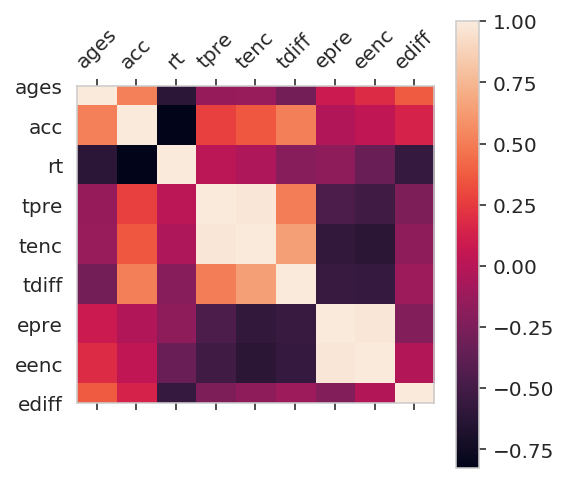

                            OLS Regression Results                            
Dep. Variable:                    acc   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     8.426
Date:                Tue, 29 Oct 2019   Prob (F-statistic):             0.0181
Time:                        14:07:29   Log-Likelihood:                 19.213
No. Observations:                   9   AIC:                            -32.43
Df Residuals:                       6   BIC:                            -31.83
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6840      0.061     11.177      0.0

/Users/Voytek/anaconda/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


In [35]:
# subject ages and behavior, from the csvs
ages = [33, 50, 31, 22, 31, 34, 27, 34, 42]
acc = [0.9, 0.967, 0.933, 0.792, 0.95, 0.958, 0.95, 0.842, 0.925]
rt = [1783.1, 1138.9, 1790.8, 2950.7, 1245.7, 722.4, 1165.2, 1602.1, 780.8]

df = pd.DataFrame({'ages': ages, 'acc': acc, 'rt': rt,
                   'tpre': avg_tau_pre, 'tenc': avg_tau_enc, 'tdiff': avg_tau_diff,
                   'epre': avg_exp_pre, 'eenc': avg_exp_enc, 'ediff': avg_exp_diff})

plt.matshow(df.corr())
plt.xticks(range(df.shape[1]), df.columns, fontsize=10, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.show()

mod = smf.ols(formula='acc ~ ages + tdiff', data=df)
res = mod.fit()
print(res.summary())
